In [240]:
import cv2
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('../'))
import pandas as pd
import datetime
import random
from utilities.helper_functions import helper_functions as hf
import config
import tdt
import re
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize.minpack import curve_fit


/tmp/ipykernel_193216/612152117.py:16: DeprecationWarning: Please use `curve_fit` from the `scipy.optimize` namespace, the `scipy.optimize.minpack` namespace is deprecated.
  from scipy.optimize.minpack import curve_fit


In [241]:
date_format = "%Y-%m-%d %H:%M:%S.%f"
# create dict to hold correspondence between photometry data, trial data, and video data keyed by day
experiment_data = dict()
for day in os.listdir(config.remote_photometry_path):
    trial_paths = [config.remote_photometry_path + day + '/' + x for x in os.listdir(config.remote_photometry_path + day) if re.match('M[1-8]_F1_M[1-8]_F2', x)]
    date = day.split('-')[-1]
    # Search through all trials recorded and find ones matching the day of photometry recording
    matching_trials = [x for x in os.listdir(config.successful_trial_path) if x[2:8] == date]
    valid_trials = []
    mice_ids = []
    # remove trials with less than 10 trials
    for trial in matching_trials:
        if pd.read_csv(config.successful_trial_path + trial).shape[0] > 10:
            trial_csv = pd.read_csv(config.successful_trial_path + trial)
            mice_ids.append(trial_csv['names'][0])
            valid_trials.append(trial)
        
    matching_trials = valid_trials
    for trial in trial_paths:
        data = None
        # find the two mouse ids by regex matching to M1-8
        mouse_id = re.findall('M[1-8]', trial)
        mouse_id = mouse_id[0]+mouse_id[1]
        # get all indices of matching mouse ids
        matching_indices = [i for i, x in enumerate(mice_ids) if x == mouse_id]
        data = tdt.read_block(trial, t2=1)
        if data is None:
            print('No data found for ' + trial)
            continue
        print('Processing ' + trial)
        start_time = data.info.start_date
        # iterate through all matching trials and find the one with the closest start time
        closest_trial = None
        closest_time_delta = 10000000
        for i in matching_indices:
            match_trial = pd.read_csv(config.successful_trial_path + matching_trials[i])
            trial_start_time = datetime.datetime.strptime(match_trial['cue_times'][0], date_format)
            if abs((start_time - trial_start_time).total_seconds()) < closest_time_delta:
                closest_time_delta = abs(start_time - trial_start_time).total_seconds()
                closest_trial = matching_trials[i]
                closest_trial_start_time = trial_start_time

        # find the video that matches closest trial
        video_times = [hf.process_time_string(name.split('_')[0]) for name in os.listdir(config.remote_video_path)]
        video_paths = [name for name in os.listdir(config.remote_video_path)]
        # iterate through all videos and find the one with the closest start time
        closest_video = None
        closest_time_delta = 10000000
        for i, video_time in enumerate(video_times):
            if abs((closest_trial_start_time - video_time).total_seconds()) <  abs(closest_time_delta):
                closest_time_delta = abs((closest_trial_start_time - video_time).total_seconds())
                closest_video = video_paths[i]
        # append trial data, video data, and photometry data to the experiment data dict
        # check if the day is already in the dict

        if str(start_time.date()) in experiment_data:
            experiment_data[str(start_time.date()) + '_2'] = {
                'trial': config.successful_trial_path + closest_trial,
                'video': config.remote_video_path + closest_video,
                'photometry': trial
            }
        else:
            experiment_data[str(start_time.date())] = {
                'trial': config.successful_trial_path + closest_trial,
                'video': config.remote_video_path + closest_video,
                'photometry': trial
            }
# save experiment data to a pickle file
with open(config.PROJECT_ROOT + '/data/experiment_data.pickle', 'wb') as handle:
    pickle.dump(experiment_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

read from t=0s to t=1s
Processing /mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230829/M5_F1_M6_F2
read from t=0s to t=1s
Processing /mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230822/M5_F1_M6_F2_1
read from t=0s to t=1s
Processing /mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230822/M5_F1_M6_F2
read from t=0s to t=1s
Processing /mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230901/M5_F1_M6_F2
read from t=0s to t=1s
Processing /mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230831/M5_F1_M6_F2
read from t=0s to t=1s
Processing /mnt/team

In [242]:
experiment_data

{'2023-08-29': {'trial': '/home/murph_4090ws/Documents/Arjun_data/data/successful_trials_by_day/20230829113352_log.csv',
  'video': '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/videos/20230829113351_SI.h264',
  'photometry': '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230829/M5_F1_M6_F2'},
 '2023-08-22': {'trial': '/home/murph_4090ws/Documents/Arjun_data/data/successful_trials_by_day/20230822152926_log.csv',
  'video': '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/videos/20230822152925_SI.h264',
  'photometry': '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230822/M5_F1_M6_F2_1'},
 '2023-08-22_2': {'trial': '/home/murph_4090ws/Documents/Arjun_data/data/successful_trials_by_day/20230822135031_log.csv',
  'video': '/mnt/teams/

In [255]:
def detect_triggers(data, threshold=0.0005):
    smoothed_data = np.convolve(data, np.ones(1000)/1000, mode='same')
    diff_data = np.diff(smoothed_data)
    diff_data = np.convolve(diff_data, np.ones(1000)/1000, mode='same')
    #plt.plot(diff_data[:1000000])
    recording = False
    triggered_data = []
    trial_indices = []
    for i in range(len(diff_data)):
        if diff_data[i] > threshold and not recording:
            recording = True
            trial_indices.append(i)
        elif diff_data[i] < -threshold and recording:
            recording = False
            
        elif recording and diff_data[i] < threshold and diff_data[i] > -threshold:
            triggered_data.append(data[i])
    return triggered_data, trial_indices

## Given a block of tdt data and a list of time deltas from the start of the trial, return a list of trials
# params:
#   stream_data_block: tdt data block object
#   delta_time: list of time deltas from the start of the trial, floating point seconds
def stream_to_trials(stream_data_block, delta_time, threshold):
    fs = stream_data_block.fs
    stream = stream_data_block.data
    _, trigger_indices = detect_triggers(stream, threshold=threshold)
    print(len(trigger_indices))
    print(len(delta_time))
    if len(trigger_indices) == len(delta_time):
        skip_index = 1
    else:
        skip_index = 1
    try:
        trials = [ stream[trigger_indices[skip_index]:][int (time * fs + fs) : int ((time + 31) * fs)] for time in delta_time]
    # catch index error
    except:
        print(delta_time[-1] * fs)
        print(trigger_indices)
        print(len(stream[trigger_indices[1]:]))
    return trials


## given a date, return an dict of photometry data, with each stream from the block broken up into trials basedon the csv
# params:
#   date: string of date in format 'YYYY-MM-DD'
#   returns: dict {
#    '465A': array(# trials, 30 secs * fs)
#    '405A': array(# trials, 30 secs * fs)
#    '465C': array(# trials, 30 secs * fs)
#    '405C': array(# trials, 30 secs * fs)
# }
def get_trial_photometry_data(key, dict):
    date_format = "%Y-%m-%d %H:%M:%S.%f"
    date_list = pd.read_csv(dict[key]['trial'])['cue_times'].to_list()
    data_block = tdt.read_block(dict[key]['photometry'])
    delta_time = [(datetime.datetime.strptime(date, date_format) - datetime.datetime.strptime(date_list[0], date_format)).total_seconds() for date in date_list]
    return {
        "465A" : stream_to_trials(data_block.streams['_465A'], delta_time, threshold=0.2),
        "405A" : stream_to_trials(data_block.streams['_405A'], delta_time, threshold=0.01),
        "corrected_A" : stream_to_trials(data_block.streams['_465A'] - data_block.streams['_405A'], delta_time, threshold=0.2),
        '465C' : stream_to_trials(data_block.streams['_465C'], delta_time, threshold=0.2),
        '405C' : stream_to_trials(data_block.streams['_405C'], delta_time, threshold=0.01),
        'corrected_C' : stream_to_trials(data_block.streams['_465C'] - data_block.streams['_405C'], delta_time, threshold=0.2),
        'fs' : data_block.streams['_465A'].fs
    }


    
def deltaFF(data, t, method='exp_fit'):
    # if method == 'poly':
    #     reg = np.polyfit(dat2, dat1, 1)
    #     a, b = reg
    #     controlFit = a*dat2 + b
    #     dff = np.divide(np.subtract(dat1, controlFit), controlFit)
    # elif method == 'subtract':
    #     dff1 = np.divide(np.subtract(dat1, np.mean(dat1)), np.mean(dat1))
    #     dff2 = np.divide(np.subtract(dat2, np.mean(dat2)), np.mean(dat2))
    #     dff = dff1 - dff2
    # elif method == 'exp_fit':
    #
    guess_a, guess_b, guess_c = np.max(data), -0.05, np.min(data)
    guess = [guess_a, guess_b, guess_c]
    exp_decay = lambda x, A, b, y0: A * np.exp(x * b) + y0
    params, cov = curve_fit(exp_decay, t, data, p0=guess, maxfev=5000)
    A, b, y0 = params
    best_fit = lambda x: A * np.exp(b * x) + y0
    dff = data-best_fit(t) + 100  # add DC offset so mean of corrected signal is positive
    dff = (dff - np.mean(dff))/np.mean(dff)
    return stats.zscore(dff), best_fit


def get_movement_success_trials(key, experiment_data):
    try:
        video_titles = os.listdir(config.movement_extracted_output_path + str(experiment_data[key]['trial'].split('/')[-1][:14]))
    except:
        return None
    move_trials = set([int(x.split('_')[2]) for x in video_titles])
    
    csv = pd.read_csv(experiment_data[key]['trial'])
    success_trials = set([int(x) for x, success in enumerate(csv['successful_trials'].to_list()) if success])
    return (success_trials.intersection(move_trials))

Top mouse in frame is F2, bottom mouse in frame is F1


In [244]:
# data = get_trial_photometry_data('2023-09-05', experiment_data)
# csv = pd.read_csv(experiment_data['2023-09-05']['trial'])

In [245]:
experiment_data_stranger = pickle.load(open(config.PROJECT_ROOT + '/data/experiment_data_strangers.pickle', 'rb'))

In [246]:
# combine all photometry data into one dict
all_photometry_data = dict()
for key in experiment_data:
    all_photometry_data[key] = experiment_data[key]
for key in experiment_data_stranger:
    all_photometry_data[key] = experiment_data_stranger[key]
all_photometry_data

{'2023-08-29': {'trial': '/home/murph_4090ws/Documents/Arjun_data/data/successful_trials_by_day/20230829113352_log.csv',
  'video': '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/videos/20230829113351_SI.h264',
  'photometry': '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230829/M5_F1_M6_F2'},
 '2023-08-22': {'trial': '/home/murph_4090ws/Documents/Arjun_data/data/successful_trials_by_day/20230822152926_log.csv',
  'video': '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/videos/20230822152925_SI.h264',
  'photometry': '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/Littermate interaction/fiber photometry data/Mice with ID/Social_Interaction-230822/M5_F1_M6_F2_1'},
 '2023-08-22_2': {'trial': '/home/murph_4090ws/Documents/Arjun_data/data/successful_trials_by_day/20230822135031_log.csv',
  'video': '/mnt/teams/

2023-08-29
read from t=0s to t=22325.31s
484
482
484
482
484
482
484
482
2023-08-22
2023-09-01
read from t=0s to t=17064.09s
369
369
369
369
369
369
369
369
28484
2023-08-31
read from t=0s to t=40196.46s
870
869
870
869
870
869
870
869
28484
2023-08-12
2023-08-30
read from t=0s to t=27430.97s
593
592
593
592
593
592
593
592
28484
2023-08-23
2023-08-18
2023-08-17
2023-08-24
read from t=0s to t=27011.65s
403
403
403
403
403
403
403
403
28484
2023-08-25
read from t=0s to t=22816.41s
494
493
494
493
494
493
494
493
2023-08-14
2023-08-16
2023-08-15
2023-09-05
read from t=0s to t=34535.59s
674
673
674
673
674
673
674
673
28484
2023-09-06
read from t=0s to t=37943.84s
741
740
741
740
741
740
741
740
28484


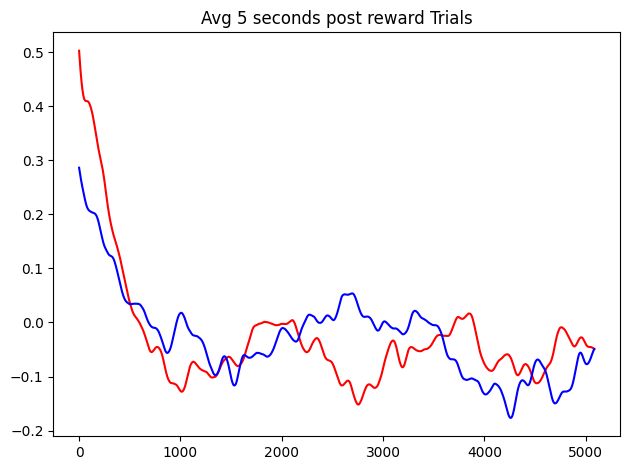

In [247]:
success_list_465A = []
success_list_465C = []
success_trial_names = []
post_reward_list_465A = []
post_reward_list_465C = []
fail_list_465A = []
fail_list_465C = []
for key in [key for key in all_photometry_data.keys() if key[-2:] != '_2']:
    print(key)
    if key == '2023-08-12' or (int(key[-2:]) < 24 and int(key[5:7]) == 8):
        continue
    data = get_trial_photometry_data(key, all_photometry_data)
    csv = pd.read_csv(all_photometry_data[key]['trial'])
    movemen_trials = get_movement_success_trials(key, all_photometry_data)
    for trial, success in enumerate(csv['successful_trials'].to_list()):
        fs = int(data['fs'])
        time_series = np.arange(1, 29, 1/data['fs'])

        if trial in movemen_trials:
            try:
                dff_465A = deltaFF((data['465A'][trial] - data['405A'][trial])[fs:len(time_series) + fs], time_series)[0]
                dff_465C = deltaFF((data['465C'][trial] - data['405C'][trial])[fs:len(time_series) + fs], time_series)[0]
                success_list_465A.append(dff_465A)
                success_list_465C.append(dff_465C)
                success_trial_names.append(key + '_' + str(trial))
                # get reward timing
                M5_reward_time = csv['mouse_R_reward_time'][trial]
                M6_reward_time = csv['mouse_L_reward_time'][trial]
                post_reward_list_465A.append(dff_465A[int((M5_reward_time - 1) * fs):int(M5_reward_time * fs) + int(4 * fs)])
                post_reward_list_465C.append(dff_465C[int((M6_reward_time - 1) * fs):int(M6_reward_time * fs) + int(4 * fs)])
            except: 
                print(len(time_series))
                continue
        else:
            try:
                fail_list_465A.append(deltaFF(data['465A'][trial][fs:len(time_series) + fs], time_series)[0])
                fail_list_465C.append(deltaFF(data['465C'][trial][fs:len(time_series) + fs], time_series)[0])
            except:
                print(len(time_series))
                continue
# average over all successful trials
mean_465A = np.mean(np.array(success_list_465A), axis=0)
mean_465C = np.mean(np.array(success_list_465C), axis=0)
# average over all failed trials
mean_465A_fail = np.mean(np.array(fail_list_465A), axis=0)
mean_465C_fail = np.mean(np.array(fail_list_465C), axis=0)

# average over all reward trials
mean_465A_reward = np.mean([y[:min([len(x) for x in post_reward_list_465A])] for y in post_reward_list_465A], axis=0)
mean_465C_reward = np.mean([y[:min([len(x) for x in post_reward_list_465C])] for y in post_reward_list_465C], axis=0)

# plot average of reward trials
fig, ax = plt.subplots(1, 1)
ax.plot(mean_465A_reward, color='red')
ax.plot(mean_465C_reward, color='blue')
ax.set_title('Avg 5 seconds post reward Trials')
fig.tight_layout()
plt.show()

# # plot the average of all successful trials
# fig, ax = plt.subplots(2, 1)
# # plot the average of all failed trials
# ax[0].plot(mean_465C_fail, color='blue')
# ax[0].plot(mean_465A_fail, color='red')
# # add title
# ax[0].set_title('Failed Trials')
# # plot the average of all successful trials
# ax[1].plot(mean_465C, color='blue')
# ax[1].plot(mean_465A, color='red')
# # add title
# ax[1].set_title('Successful Trials')
# # add spacing between plots
# fig.tight_layout()
# plt.show()

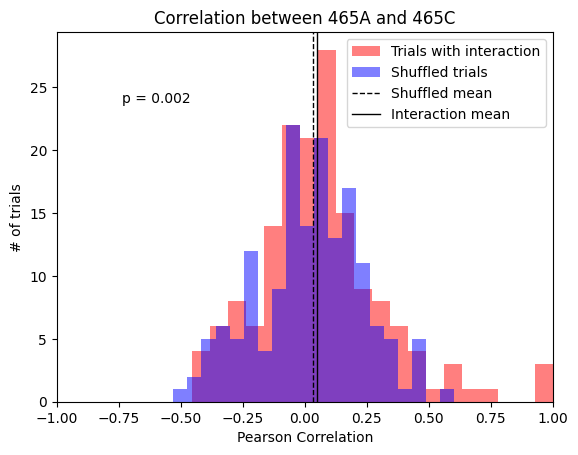

In [248]:
# iterate through all pairs of data on successful trials and find the correlation between 465A and 465C
success_correlation = []
shuffled_correlation = []
success_p = []
shuffled_p = []
for success_A, success_C in zip(success_list_465A, success_list_465C):
    corr, p = stats.pearsonr(success_A, success_C)
    success_correlation.append(corr)
    success_p.append(p)

# randomly shuffle the data and find the correlation between 465A and 465C
shuffled_465A = (np.array(success_list_465A))
shuffled_465C = (np.array(success_list_465C))
np.random.shuffle(shuffled_465A)
np.random.shuffle(shuffled_465C)

for shuffled_A, shuffled_C in zip(shuffled_465A, shuffled_465C):
    corr, p = stats.pearsonr(shuffled_A, shuffled_C)
    shuffled_correlation.append(corr)
    shuffled_p.append(p)


# shuffle the data 1000 times and find the mean correlation between 465A and 465C
shuffled_correlation_distribution = []
# for i in range(100):
#     np.random.shuffle(shuffled_465A)
#     np.random.shuffle(shuffled_465C)
#     for shuffled_A, shuffled_C in zip(shuffled_465A, shuffled_465C):
#         shuffled_correlation_distribution.append(stats.pearsonr(shuffled_A, shuffled_C)[0])

p_value = (stats.ttest_1samp(success_correlation, 0))[1]

# make a histogram of the correlation between 465A and 465C
fig, ax = plt.subplots(1, 1)
ax.hist(success_correlation, bins=20, color='red', label='Trials with interaction', alpha=0.5)
ax.hist(shuffled_correlation, bins=20, color='blue', label='Shuffled trials', alpha=0.5)
# take the mean of the shuffled correlation and plot it as a vertical line
ax.axvline(np.median(shuffled_correlation), color='black', linestyle='dashed', label='Shuffled mean', linewidth=1)
# take the mean of the success correlation and plot it as a vertical line
ax.axvline(np.median(success_correlation), color='black', linestyle='solid', label='Interaction mean', linewidth=1)
# label the vertical lines
ax.legend()
ax.set_title('Correlation between 465A and 465C')
# add p value to the plot
ax.text(0.2, 0.8, 'p = ' + str(p_value)[:5], horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.set_xlabel('Pearson Correlation')
ax.set_ylabel('# of trials')
ax.set_xlim(-1, 1)
# save as an svg
fig.savefig(config.PROJECT_ROOT + '/data/media/figures/correlation.svg')
plt.show()

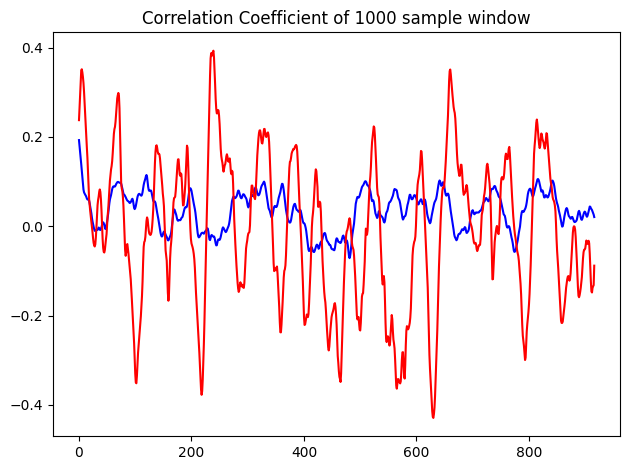

In [249]:

## Run a moving window of 1000 samples over the data and calculate the correlation coefficient
# params:
#   data: list of data
#   window_size: size of the window to calculate correlation over
#   step_size: size of the step to move the window by
#   returns: list of correlation coefficients
def moving_window_correlation(data_x, data_y, window_size, step_size):
    # Assert x and y same size if not same size, print sizes
    assert len(data_x) == len(data_y), 'Data x and y not same size' + str(len(data_x)) + ' ' + str(len(data_y))
    correlation_list = []
    for i in range(0, len(data_x) - window_size, step_size):
        correlation_list.append(stats.pearsonr(data_x[i:i+window_size], data_y[i:i+window_size])[0])
    return correlation_list
fig, ax = plt.subplots(1, 1)
test_corr = []
for success_A, success_C in zip(success_list_465A, success_list_465C):
    test_corr.append(moving_window_correlation(success_A, success_C, 1000, 30))
    # plot both on the same graph

ax.plot(np.mean(test_corr, axis=0), color='blue')

# shuffle the data and calculate the correlation coefficient
shuffled_success_list_A = random.sample(fail_list_465A, 10)
shuffled_success_list_C = random.sample(fail_list_465C, 10)

test_corr_shuffled = []
for success_A, success_C in zip(shuffled_success_list_A, shuffled_success_list_C):
    test_corr_shuffled.append(moving_window_correlation(success_A, success_C, 1000, 30))
    # plot both on the same graph

ax.plot(np.mean(test_corr_shuffled, axis=0), color='red')
# for fail_A, fail_C in zip(fail_list_465A, fail_list_465C):
#     test_corr = moving_window_correlation(fail_A, fail_C, 1000, 30)
#     # plot both on the same graph
#     ax.plot(test_corr, color='red')
# normalized_reward_465_A = [y[:min([len(x) for x in post_reward_list_465A])] for y in post_reward_list_465A]
# normalized_reward_465_C = [y[:min([len(x) for x in post_reward_list_465C])] for y in post_reward_list_465C]
# for reward_A, reward_C in zip(normalized_reward_465_A, normalized_reward_465_C):
#     test_corr = moving_window_correlation(reward_A, reward_C, 1000, 1)
#     # plot both on the same graph
#     ax.plot(test_corr, color='green')
ax.set_title('Correlation Coefficient of 1000 sample window')
fig.tight_layout()
plt.show()

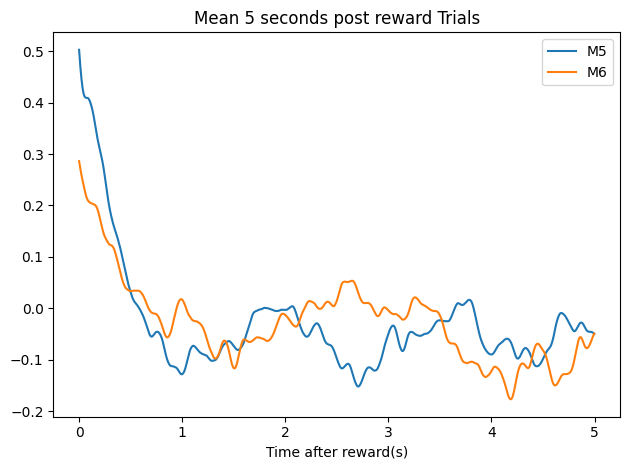

In [250]:
# average over all reward trials
mean_465A_reward = np.mean([y[:min([len(x) for x in post_reward_list_465A])] for y in post_reward_list_465A], axis=0)
mean_465C_reward = np.mean([y[:min([len(x) for x in post_reward_list_465C])] for y in post_reward_list_465C], axis=0)

# plot average of reward trials
time_series = np.arange(0, 5, 1/data['fs'])[:-3]
fig, ax = plt.subplots(1, 1)
ax.plot(time_series, mean_465A_reward, label='M5')
ax.plot(time_series, mean_465C_reward, label='M6')
ax.set_title('Mean 5 seconds post reward Trials')
ax.set_xlabel('Time after reward(s)')
fig.tight_layout()
# legend
ax.legend()
plt.show()
# save fig as svg
fig.savefig(config.PROJECT_ROOT + '/data/media/figures/mean_reward.svg', format='svg')

In [251]:
# List of trial to proces chosen by hand along with frame numbers, recorded at 25 fps
# 8-24
trials_8_24_f2 = {
    7 : [0 , 229],
    10 : [198 , 454],
    15 : [667, 748],
    21 : [220, 384],
    26 : [0, 748],
    50 : [549, 748],
    54 : [127, 368],
    
}
trials_8_24_f1 = {
    17 : [0, 108],
    19 : [544, 679],
    20 : [31, 191],
    31 : [599 , 748],
    35 : [121, 748],
    61 : [0, 172]
}
trials_8_24_combined = {
    16 : [0, 748],
    18 : [272, 748],
    39 : [0, 270],
    78 : [58, 748],
    141 : [184 , 748],
}
trials_8_24_nothing = {
    230 : [0, 748],
}

trials_9_1_f2 = {
    12 : [0, 748],
    45 : [0, 748],
    70 : [600, 748],
    108 : [279, 506],
    326 : [540, 748],
    3 : [576, 748],
    4 : [0, 197],
    5 : [20, 748],
    6 : [555 , 748],

}

trials_9_1_f1 = {
    83 : [0, 545],
}

trials_8_31_combined = {
    1 : [368, 748],
    839 : [106, 748],
}

trials_8_31_f1 = {
    212 : [0, 748],
    5 : [0, 748],
    83 : [504, 618],
    212 : [0, 748],
}

trials_8_30_combined = {
    2 : [438, 748],
    9 : [0, 350],
    15 : [0, 611],
    27 : [0, 482],
}

read from t=0s to t=27011.65s
403
403
403
403
403
403
403
403
read from t=0s to t=27430.97s
593
592
593
592
593
592
593
592


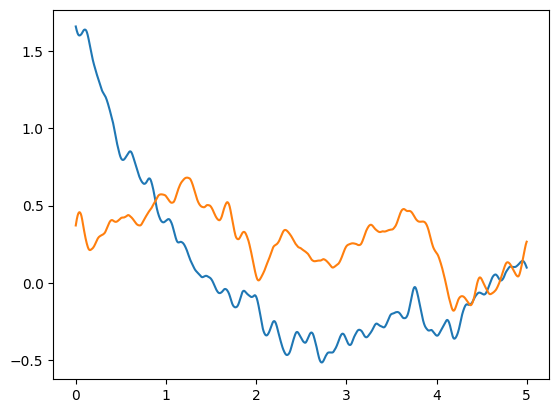

In [252]:
data = get_trial_photometry_data('2023-08-24', experiment_data)
csv = pd.read_csv(experiment_data['2023-08-24']['trial'])
success_list_465A = []
success_list_465C = []
for key in trials_8_24_combined:
    fs = int(data['fs'])
    interaction_start = trials_8_24_combined[key][0]/25.0
    time_series = np.arange(interaction_start, interaction_start + 5, 1/data['fs'])
    start = int(time_series[0] * fs)
    end = int(time_series[-1] * fs)
    dff_465A = deltaFF(data['465A'][key][fs:-fs], np.arange(1,29, 1/data['fs'])[:len(data['465A'][key][fs:-fs])])[0]
    dff_465C = deltaFF(data['465C'][key][fs:-fs], np.arange(1,29, 1/data['fs'])[:len(data['465C'][key][fs:-fs])])[0]
    success_list_465A.append(dff_465A[start :end])
    success_list_465C.append(dff_465C[start :end])

data = get_trial_photometry_data('2023-08-30', experiment_data)
csv = pd.read_csv(experiment_data['2023-08-30']['trial'])
for key in trials_8_30_combined:
    fs = int(data['fs'])
    interaction_start = trials_8_30_combined[key][0]/25.0
    time_series = np.arange(interaction_start, interaction_start + 5, 1/data['fs'])
    start = int(time_series[0] * fs)
    end = int(time_series[-1] * fs)
    dff_465A = deltaFF(data['465A'][key][fs:-fs], np.arange(1,29, 1/data['fs'])[:len(data['465A'][key][fs:-fs])])[0]
    dff_465C = deltaFF(data['465C'][key][fs:-fs], np.arange(1,29, 1/data['fs'])[:len(data['465C'][key][fs:-fs])])[0]
    success_list_465A.append(dff_465A[start :end])
    success_list_465C.append(dff_465C[start :end])

# normalize length of all trials
min_length = min([len(x) for x in success_list_465A])
success_list_465A = [x[:min_length] for x in success_list_465A]
success_list_465C = [x[:min_length] for x in success_list_465C]
# average over all successful trials
mean_465A = np.mean(np.array(success_list_465A), axis=0)
mean_465C = np.mean(np.array(success_list_465C), axis=0)
# plot

plt.plot(np.arange(0, 5, 5/len(mean_465A)), mean_465A)
plt.plot(np.arange(0, 5, 5/len(mean_465A)), mean_465C)

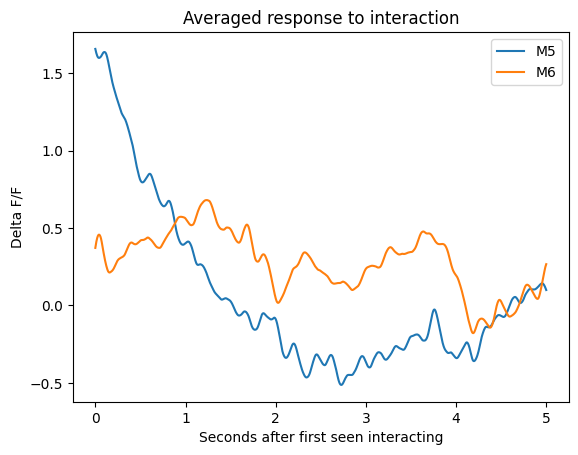

In [253]:
fig, ax =  plt.subplots(1,1)
plt.plot(np.arange(0, 5, 5/len(mean_465A)), mean_465A)
plt.plot(np.arange(0, 5, 5/len(mean_465A)), mean_465C)
plt.title('Averaged response to interaction')
plt.xlabel('Seconds after first seen interacting')
plt.ylabel('Delta F/F')
plt.legend(['M5', 'M6'])

# save the current plot
fig.savefig(config.PROJECT_ROOT + '/data/media/figures/averaged_response.svg', format='svg', dpi=1200)
plt.show()

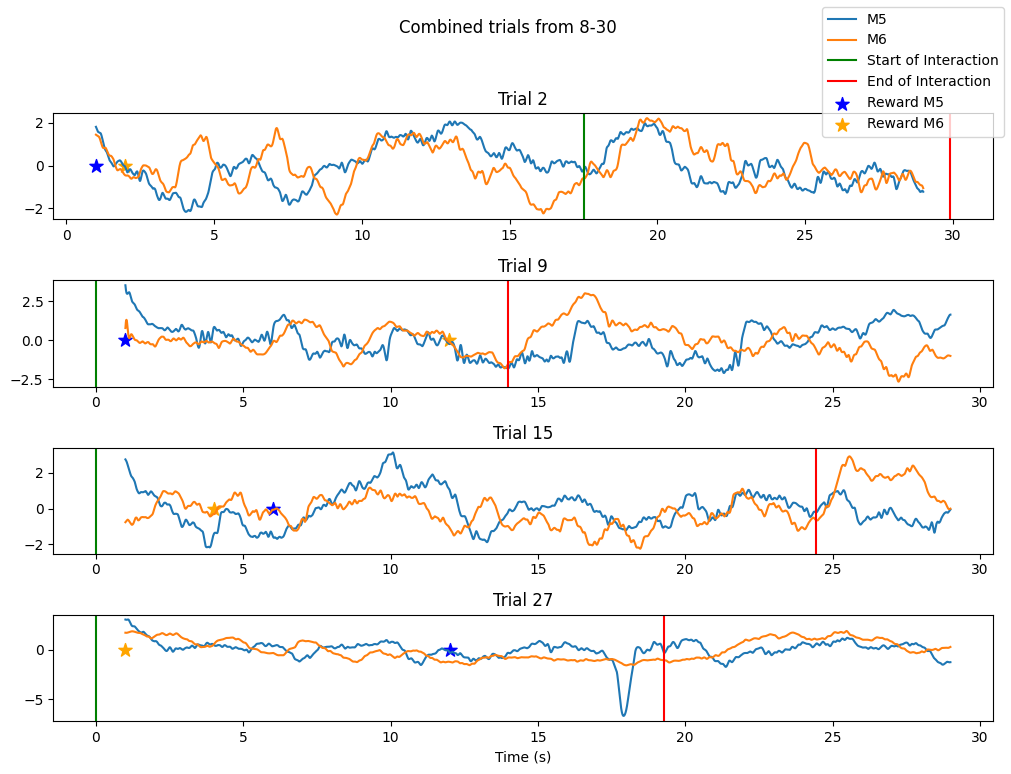

In [254]:
from matplotlib.animation import FuncAnimation
# plot 465A on right graph
trial_dict = trials_8_30_combined
fig, axes = plt.subplots(len(trial_dict.keys()), 1, figsize=(10, 2 * len(trial_dict.keys())))
trim_end  = -500
trim_start = 500
for key, axs in zip(trial_dict, axes):
    ind = key
    start_x = trial_dict[key][0] / 25.0
    end_x = trial_dict[key][1] / 25.0
    fs = int(data['fs'])
    time_series = np.arange(1, 29, 1/data['fs'])[0:len(data['465A'][ind][fs:-fs])]
    dff465A = deltaFF(data['465A'][ind][fs:-fs], time_series)[0]
    dff405A = deltaFF(data['405A'][ind][fs:-fs], time_series)[0]
    dff465C = deltaFF(data['465C'][ind][fs:-fs], time_series)[0]
    dff405C = deltaFF(data['405C'][ind][fs:-fs], time_series)[0]
    dff_diffA = dff465A 
    dff_diffC = dff465C 
    reward_time_L = csv['mouse_L_reward_time'][ind]
    reward_time_R = csv['mouse_R_reward_time'][ind]    
    # high pass dff_dffC
    line1 = axs.plot(time_series, dff_diffA, label='M5')
    line2 = axs.plot(time_series, dff_diffC, label='M6')
    # plot vertical lines 
    line3 = axs.axvline(x=start_x, color='g', label='Start of Interaction')
    line4 = axs.axvline(x=end_x, color='r', label='End of Interaction')
    # plot a star at the reward time
    if reward_time_L is not None:
        star1 = axs.scatter(reward_time_L, 0, marker='*', color='b', s=100, label='Reward M5')
    
    if reward_time_R is not None:
        star2 = axs.scatter(reward_time_R, 0, marker='*', color='orange', s=100, label='Reward M6')
    axs.set_title('Trial ' + str(key))
# add legend to figure
fig.legend(loc='upper right', handles=[line1[0], line2[0], line3, line4, star1, star2])
fig.subplots_adjust(hspace=0.5)
# label x axis time in seconds
axes[-1].set_xlabel('Time (s)')
# add title 'M5 only trials'
fig.suptitle('Combined trials from 8-30')
# adjust title spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# save as svg  
fig.savefig(config.PROJECT_ROOT + '/data/media/figures/8-30-combined.svg', format='svg', dpi=1200)

data